Demonstrate making and applying calibration of phase and amplitude for a scan.

In general, the "calbration" data are calculated with a direct loop-back and then are applied to data collected while connected to actual resonators.  In these examples, we retain the loop back connection for both the calibration and the data.  This should result in "flat" scans in amplitude and phase.

In [1]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
import pickle
soc = TopSoc()

In [2]:
fNyIn = soc.fsIn/2
print("fNyIn =",fNyIn)

fNyIn = 1228.8


In [3]:
# Define the area to calibrate, based on an (arbitrary) mixer setting
fMixer = 0.75*soc.fsIn
print("fMixer =",fMixer)
soc.set_mixer(fMixer)
f0 = fMixer + 85.4
f1 = fMixer + 95.6
fTone = 0.5*(f0+f1)

fMixer = 1843.1999999999998


measure nominal dealy for fTone=1933.700000  outCh=38


  0%|          | 0/20 [00:00<?, ?it/s]

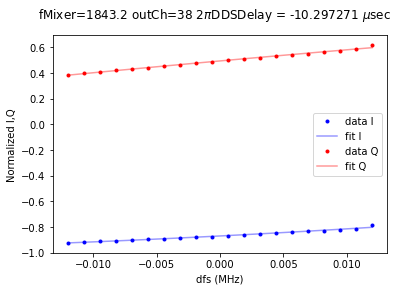

In [4]:
# Measure the nominal delay near fTone
scan = Scan.Scan(soc)
outCh = scan.soc.outFreq2ch(fTone)
print("measure nominal dealy for fTone=%f  outCh=%d"%(fTone, outCh))
nominalDelay = scan.measureNominalDelay(outCh, decimation=2, doProgress=True, doPlot=True)

In [5]:
# Make a calibration with nt transfers at nf frequencies, with the nominalDelay correction applied
nt,nf = 1,201
print("f0 =",f0)
print("f1 =",f1)
calibration = scan.makeCalibration(fMixer, f0, f1, nf=nf, nt=nt, doProgress=True,
                            nominalDelay=nominalDelay)
fscan = calibration['fscan']
print("delayApplied =",fscan['delayApplied'])


f0 = 1928.6
f1 = 1938.7999999999997
makeCalibration:  all fis zero


  0%|          | 0/201 [00:00<?, ?it/s]

 Scan applyDelay:  apply delay = -10.297271121154958
delayApplied = -10.297271121154958


In [6]:
# Save this calibration for use in the next tutorial
with open("calibration-demo-nyquist.pkl", 'wb') as file:
    pickle.dump(calibration, file)

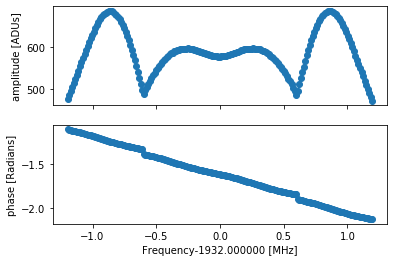

In [7]:
# Take a look at part of the calibration data, for one of the PFB bins
iTone = 2
Scan.fscanPlot(fscan, iTone)


In [8]:
# For convenience, arrange these points as a single spectrum
spectrum = Scan.fscanToSpectrum(fscan)

In [9]:
# These frequencies define where there will be discontinuities in I,Q values
importlib.reload(Scan)
scan = Scan.Scan(soc)
fList = scan.makeFList(fMixer, f0, f1,verbose=True)
print(fList)

input boundaries  freq=1927.80 fEnd=1939.80
[1928.4 1929.  1930.2 1930.8 1931.4 1932.6 1933.2 1933.8 1935.  1935.6
 1936.2 1937.4 1938.  1938.6 1939.8]


Text(0.5, 0, 'frequency (MHz)')

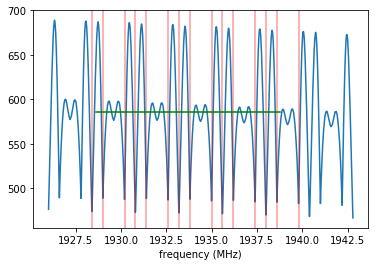

In [10]:
# Plot the amplitudes, along with vertical lines showing where discontinuities are.  The horizontal green line shows the frequency range requested
plt.plot(spectrum[0],spectrum[1])
for f in fList:
    plt.axvline(f,color='r', alpha=0.4)
aMean = spectrum[1].mean()
plt.plot([f0,f1],[aMean,aMean], 'g')
plt.xlabel("frequency (MHz)")

f0 = 1928.6
f1 = 1938.7999999999997


Text(0.5, 0, 'frequency (MHz)')

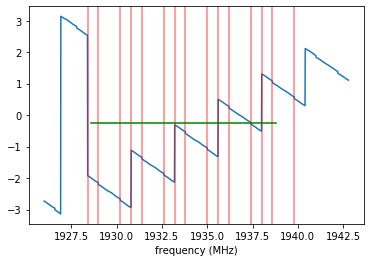

In [11]:
# Plot the phases, along with vertical lines showing where discontinuities are
plt.plot(spectrum[0],spectrum[2])
print("f0 =",f0)
print("f1 =",f1)
for f in fList:
    plt.axvline(f,color='r', alpha=0.5)
pMean = spectrum[2].mean()
plt.plot([f0,f1],[pMean, pMean], 'g')
plt.xlabel("frequency (MHz)")

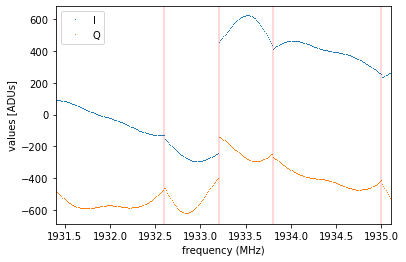

In [12]:
# zoom in a bit and show I, Q values and discontinuities
fMiddle = 0.5*(f0+f1)
fStart = fMiddle-2.3
fEnd = fMiddle+1.4
def iqPlot(fStart, fEnd):
    inds = (spectrum[0] > fStart ) & (spectrum[0] < fEnd)
    sx = spectrum[1]*np.exp(1j*spectrum[2])
    si = np.real(sx)
    sq = np.imag(sx)
    plt.plot(spectrum[0][inds],si[inds], ',', label="I")
    plt.plot(spectrum[0][inds],sq[inds], ',', label="Q")
    for f in fList:
        plt.axvline(f,color='r', alpha=0.2)
    plt.xlim((fStart,fEnd))
    plt.legend()
    plt.xlabel("frequency (MHz)")
    plt.ylabel("values [ADUs]")
iqPlot(fStart, fEnd)

In [13]:
# Pretend we have a few frequencies we want to study.  Define tones of equal amplitude and random phases and scan
nTones = 4
testFreqs = fStart + 2.345*np.arange(nTones)

testAmps = 0.9*np.ones(len(testFreqs))/len(testFreqs)
np.random.seed(1234991)
testFis = np.random.uniform(0, 2*np.pi, size=len(testFreqs))
bandwidth = 0.4 # MHz
nf = 50
decimation = 2
nt = 3
doProgress = True

testFScan = scan.fscan(testFreqs, testAmps, testFis, bandwidth, nf, decimation,nt, doProgress=doProgress)


  0%|          | 0/50 [00:00<?, ?it/s]

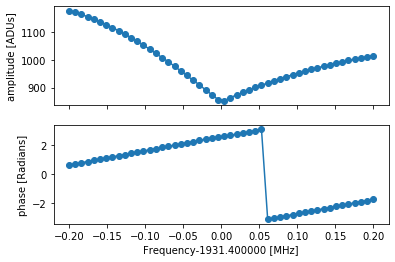

In [14]:
# Plot the measured amplitude,phase of one of the tones
Scan.fscanPlot(testFScan, 0)

In [15]:
# Apply the calibration
tfsCalib = scan.applyCalibration(testFScan, calibration, amplitudeMax=5000)


 Scan applyDelay:  apply delay = -10.297271121154958


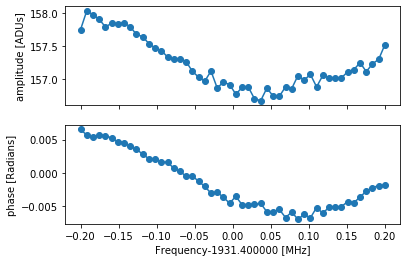

In [16]:
# Plot the calibrated amplitude,phase of one of the tones
Scan.fscanPlot(tfsCalib, 0)

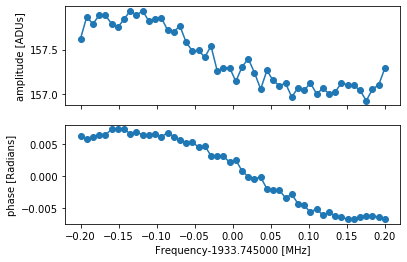

In [17]:
Scan.fscanPlot(tfsCalib, 1)

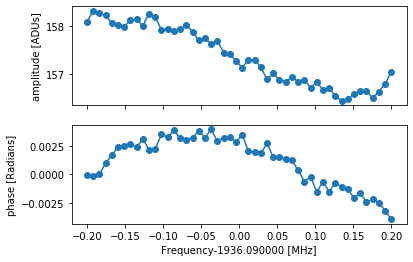

In [18]:
Scan.fscanPlot(tfsCalib, 2)

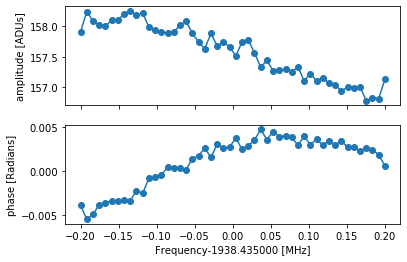

In [19]:
Scan.fscanPlot(tfsCalib, 3)